#### Libraries

In [53]:
# Standard
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Sklearn
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#### Settings

In [2]:
# Display all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Notebook random state
random_state = 421

# Set visuals to default
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Device
# folder = 'C:/Users/nuke2/Desktop/NW Work/Data/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Desktop
folder = 'C:/Users/Sam/Desktop/NW Work/DATA/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Laptop

# Question 2

#### Generate Data

In [3]:
# Set variables for simulated data
n_features = 15
n_classes = 3
n_informative = 6

# Generate random multidimensional data with 1000 samples and 15 features
X_2, y_2 = make_classification(n_samples=1000, 
                               n_features=n_features,
                               n_classes=n_classes,
                               n_informative=n_informative,
                               random_state=random_state)

### Build a K-means function from scratch (without using sklearn) and make assumptions to simplify the code as needed

In [4]:
# Initialize random centroids
def random_centroids(X, k, random_state=random_state):
    random.seed(random_state)
    num_samples, num_features = X.shape
    centroids = X[np.random.choice(num_samples, k, replace=False), :]
    return centroids

# Find distances for each point
def find_distance(X, k, centroids):
    num_samples, num_features = X.shape
    distances = np.zeros((num_samples, k))
    for cluster in range(k):
            distances[:, cluster] = np.linalg.norm(X - centroids[cluster, :], axis=1)
    return distances

# Assign labels to all points
def assign_labels(distances):
    cluster_assignment = np.argmin(distances, axis=1)
    return cluster_assignment

# Updates centroids for each cluster
def update_centroids(X, labels, k, centroids):
    for cluster in range(k):
            centroids[cluster, :] = np.mean(X[labels == cluster, :], axis=0)
    return centroids

# K-means from scratch function
def kmeans_scratch(data, k, max_iter=100, random_state=random_state):
    random.seed(random_state)
    
    # Init random centroids
    centroids = random_centroids(data, k)
    centroids_old = centroids.copy()
    
    for iteration in range(max_iter):
        # Calculate distances for each point
        distances = find_distance(data, k, centroids)
        # Get labels
        labels = assign_labels(distances)
        # Update centroids
        centroids = update_centroids(data, labels, k, centroids)
        
        if np.array_equal(centroids, centroids_old):
            break
            
        centroids_old = centroids.copy()
    
    return labels, centroids

### Use the elbow method to find an appropriate value for k

In [5]:
def elbow_plot(data):
    # Set the range of k values to try
    k_range = range(1, 11)

    # Initialize an empty list to store the WSS values for each k
    wss_values = []

    # Compute the WSS values for each k
    for k in k_range:
        # Run K-Means clustering with the current value of k
        labels, centroids = kmeans_scratch(data, k)

        # Compute the sum of squared distances of samples to their closest cluster center
        distances = find_distance(data, k, centroids)
        wss = np.sum(np.min(distances, axis=1) ** 2)
        wss_values.append(wss)

    # Plot the WSS values vs. k
    plt.plot(k_range, wss_values, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.title('Elbow method for optimal k')
    plt.show()

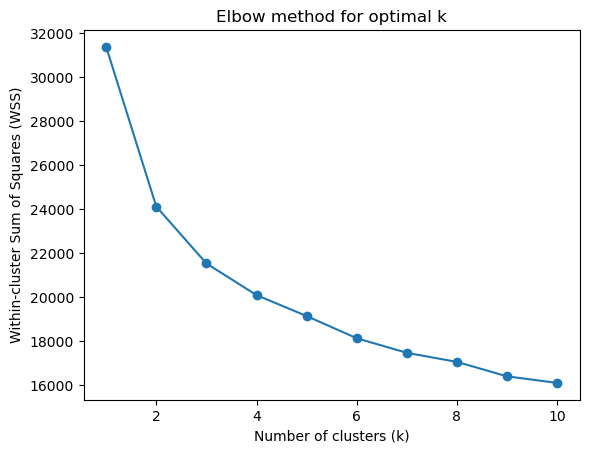

In [6]:
elbow_plot(X_2)

k=3 looks to be a good elbow point

### Use the silhouette plot to evaluate your clusters

In [7]:
def plot_silhouettes(data, labels, k):    
    # Compute the silhouette score for the clustering result
    silhouette_avg = silhouette_score(data, labels)

    # Compute the silhouette values for each sample
    silhouette_values = silhouette_samples(data, labels)

    # Set up the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 4)

    # Set the color map for the plot
    cmap = cm.get_cmap("nipy_spectral")

    # Plot the silhouette values for each sample
    y_lower = 10
    for i in range(k):
        # Check for empty clusters
        if np.sum(labels == i) == 0:
            continue

        # Aggregate the silhouette values for samples in cluster i
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size

        # Set the color for the current cluster
        color = cmap(float(i) / k)

        # Fill in the silhouette plot for the current cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plot with the cluster number at the middle
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    # Set the plot properties
    ax.set_title(f"Silhouette plot k={k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    plt.show()

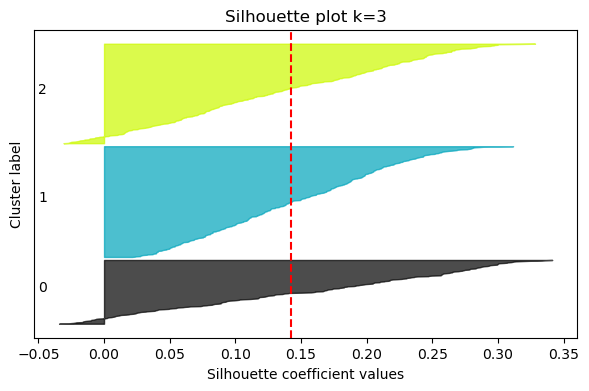

In [8]:
k=3
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

The clusters look to be alright. There are not many negative Silhouette coefficient values which indicates we may have found the best clusters. 

### Re-cluster the data to see if you can improve your results

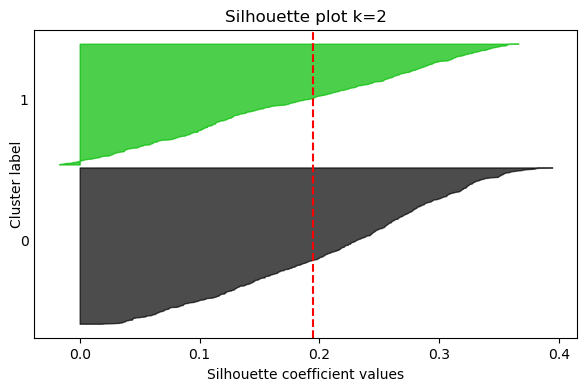

In [9]:
k=2
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

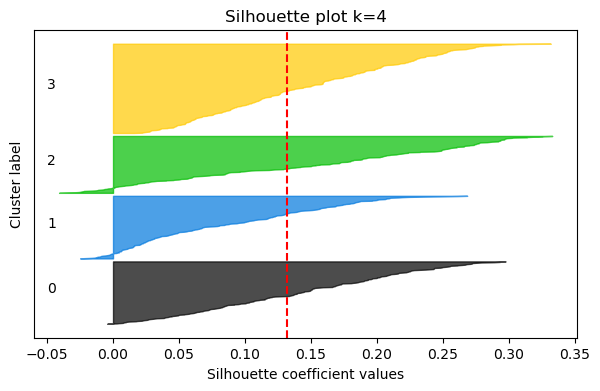

In [10]:
k=4
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

As we can see above, there seem to be good results for k=2 and poor results for k=4. k=2 only has a few negative silhouette values while k=4 has many negative silhouette values.

### Perform PCA on the original dataset and retain the most important PCs.

In [11]:
# 3 components seem to explain most of the variance hence n_components=5
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_2)

### Run K-means on the PCA output, compare results with respect to cluster quality and time taken

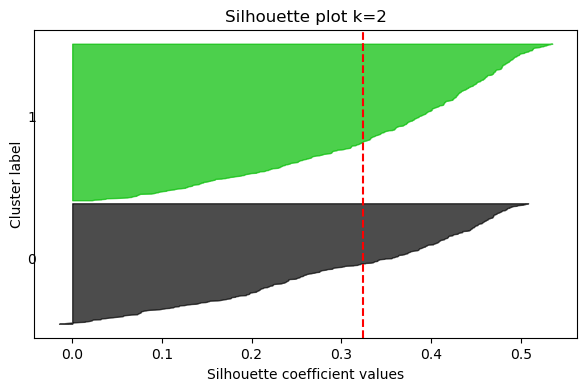

In [12]:
k=2
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

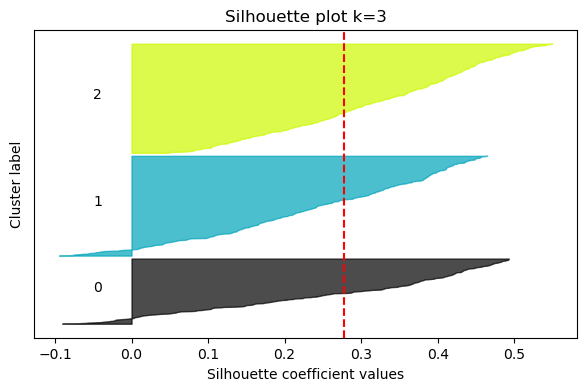

In [13]:
k=3
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

After looking at the results we can see clustering with two groups performs better when using the three most important principal components, while clustering with three groups performs worse.

# Question 3

In [14]:
# Read data
df_3 = pd.read_csv(folder, low_memory=False)
df_3.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,GeoLocation,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,916,916.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,POINT (-92.27449074299966 34.74865012400045),NaN,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,2227,2227.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-106.13361092099967 38.843840757000464),NaN,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,708,708.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,POINT (-77.036871 38.907192),NaN,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,3520,3520.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,POINT (-83.62758034599966 32.83968109300048),NaN,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,123,123.0,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,NaN,NaN,NaN,NaN,POINT (-84.71439026999968 44.6613195430005),NaN,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN


### Data Transformation

In [15]:
# Retain a limited subset of the data for the year 2020
df_3_filtered = df_3[(df_3.YearStart == 2020)]

# Set questions
q_1 = 'Mortality from heart failure'
q_2 = 'Mortality from total cardiovascular diseases'
q_3 = 'Mortality from diseases of the heart'
q_4 = 'Mortality from coronary heart disease'

# Retain a limited subset of Questions
df_3_filtered = df_3_filtered[(df_3_filtered.Question.isin([
    q_1, q_2, q_3, q_4
]))]

# Filter stratification
df_3_filtered_gender = df_3_filtered.copy()
df_3_filtered_gender = df_3_filtered_gender[df_3_filtered_gender.StratificationCategory1=='Gender']

# Create clustering dataframe for gender
df_3_filtered_gender = df_3_filtered_gender.groupby(['Question', 
                                                     'LocationAbbr', 
                                                     'Stratification1']).agg('mean', numeric_only=True)
df_3_filtered_gender = df_3_filtered_gender[['DataValueAlt']]

# Retrieve data for each question and create separate dataframes
heart_failure = df_3_filtered_gender.loc[q_1].reset_index().copy()
total_cardiovascular_diseases = df_3_filtered_gender.loc[q_2].reset_index().copy()
diseases_of_the_heart = df_3_filtered_gender.loc[q_3].reset_index().copy()
coronary_heart_disease = df_3_filtered_gender.loc[q_4].reset_index().copy()

# Rename column for heart_failure dataframe
heart_failure = heart_failure.rename(columns={'DataValueAlt': 'heart_failure'})

# Create a new dataframe with cleaned data
cleaned_data = heart_failure.copy()
cleaned_data['total_cardiovascular_diseases'] = total_cardiovascular_diseases['DataValueAlt']
cleaned_data['diseases_of_the_heart'] = diseases_of_the_heart['DataValueAlt']
cleaned_data['coronary_heart_disease'] = coronary_heart_disease['DataValueAlt']

# Preview the cleaned_data dataframe
cleaned_data.head()

,LocationAbbr,Stratification1,heart_failure,total_cardiovascular_diseases,diseases_of_the_heart,coronary_heart_disease
0,AK,Female,131.866667,262.666667,182.933333,81.933333
1,AK,Male,155.633333,390.300000,298.900000,183.333333
2,AL,Female,1297.700000,3307.266667,2414.400000,780.133333
3,AL,Male,1276.800000,3643.966667,2861.333333,1131.600000
4,AR,Female,924.233333,1934.433333,1446.166667,763.700000


### Exploratory Data Analysis

In [16]:
# Show descriptive statistics
for question in ['heart_failure', 'total_cardiovascular_diseases', 'diseases_of_the_heart', 'coronary_heart_disease']:
    print(cleaned_data[question].describe())

count     102.000000
mean     1440.632026
std      1323.853324
min       131.866667
25%       445.941667
50%      1148.033333
75%      1727.875000
max      7169.733333
Name: heart_failure, dtype: float64
count      102.000000
mean      3206.275817
std       3233.032136
min        262.666667
25%        932.741667
50%       2266.116667
75%       3778.533333
max      16745.166667
Name: total_cardiovascular_diseases, dtype: float64
count      102.000000
mean      2407.290850
std       2407.828103
min        182.933333
25%        701.450000
50%       1766.050000
75%       2932.008333
max      12594.633333
Name: diseases_of_the_heart, dtype: float64
count     102.000000
mean     1321.183333
std      1480.757697
min        81.933333
25%       411.075000
50%       835.333333
75%      1537.858333
max      7996.266667
Name: coronary_heart_disease, dtype: float64


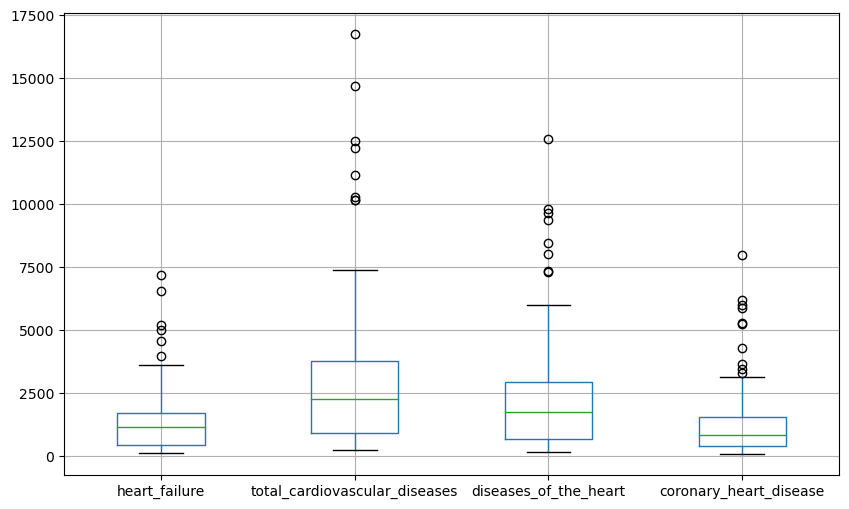

In [17]:
# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
cleaned_data.boxplot(ax=ax)
plt.show()

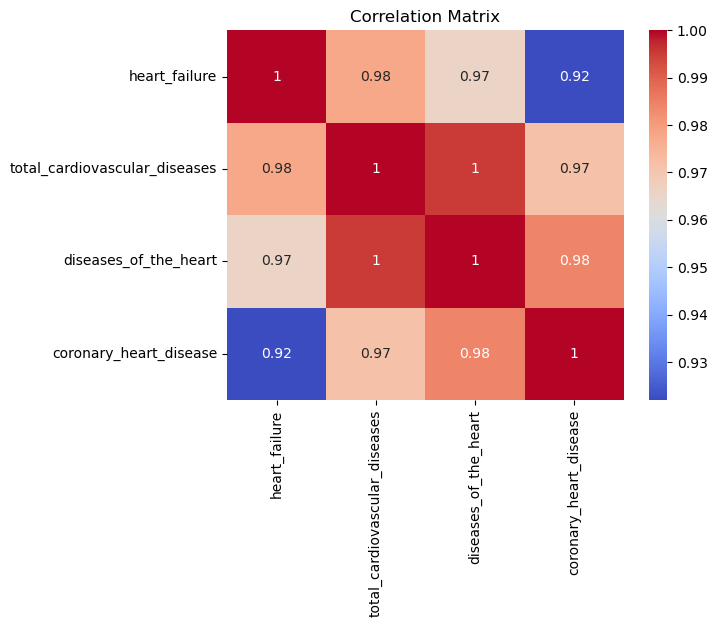

In [18]:
# Create a correlation matrix
corr_matrix = cleaned_data.corr(numeric_only=True)

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

plt.title('Correlation Matrix')
plt.show()

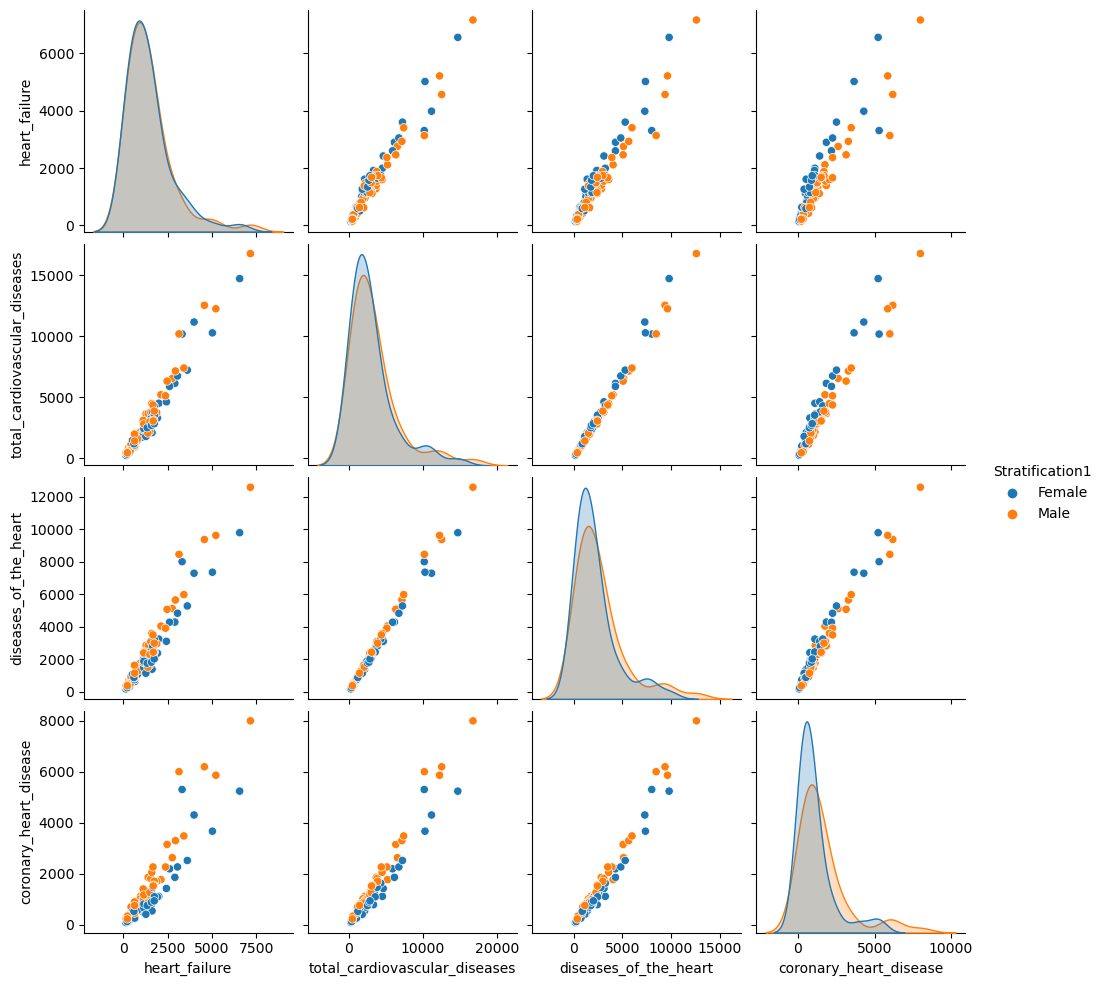

In [19]:
sns.pairplot(cleaned_data, hue='Stratification1')
plt.show()

### Clustering

Using these four questions:
- Mortality from heart failure
- Mortality from total cardiovascular diseases
- Mortality from diseases of the heart
- Mortality from coronary heart disease

We can perform cluster analysis to find groups of people that are highly likely to have these problems.

In [20]:
# Scale data
scaler = StandardScaler()
cleaned_data.iloc[:, 2:] = scaler.fit_transform(cleaned_data.iloc[:, 2:])

# Get first two PCs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cleaned_data.iloc[:, 2:])
df_pca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#### KMeans

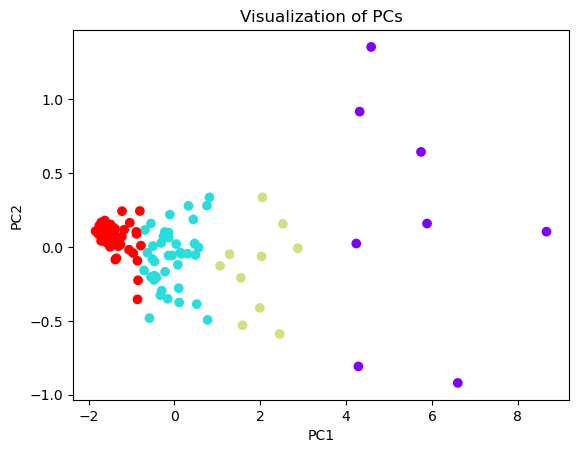

In [32]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

kmeans.fit(cleaned_data.iloc[:, 2:])

labels = kmeans.labels_

n_labels = len(set(labels))
label_colors = cm.rainbow(np.linspace(0, 1, n_labels))
cmap = ListedColormap(label_colors)

plt.scatter(df_pca['PC1'], df_pca['PC2'], c=labels, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of PCs')
plt.show()

#### Hierarchical Clustering

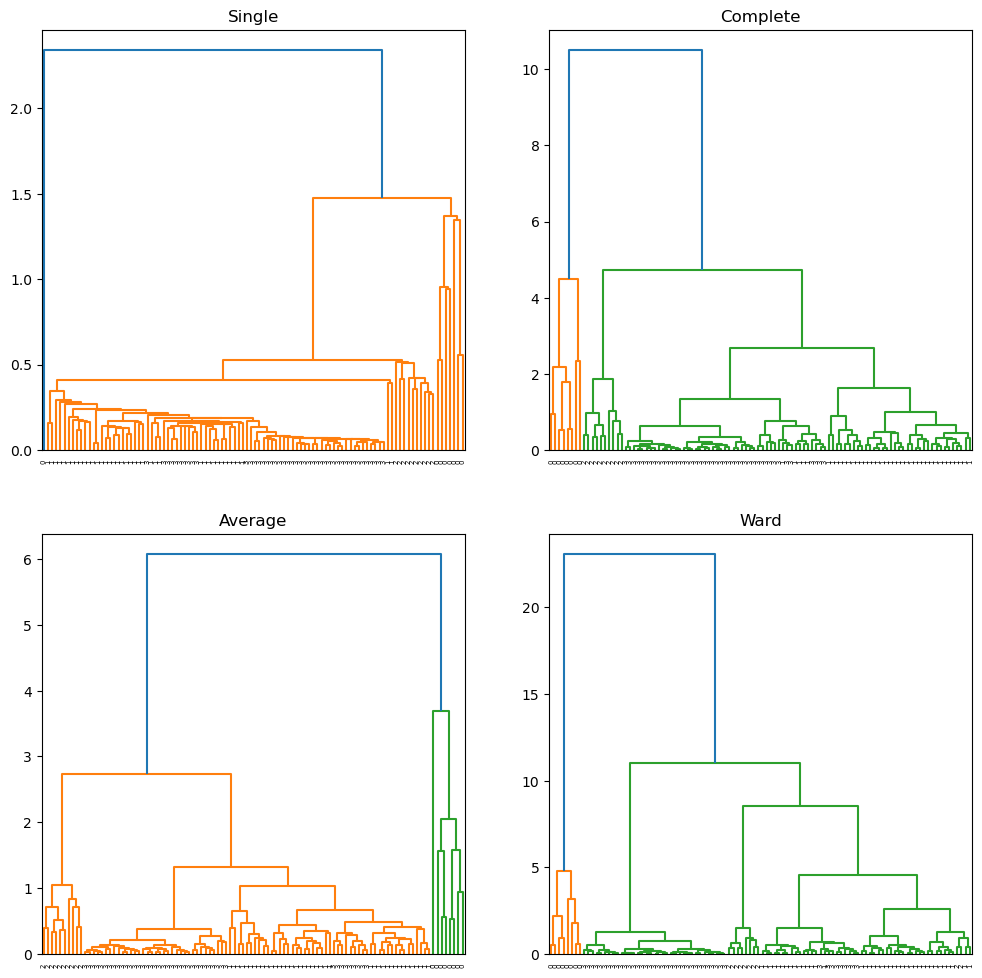

In [42]:
# convert data format for hierachical clustering
dat_c = cleaned_data.iloc[:, 2:].to_numpy()

# construct the linkage
Z1 = linkage(dat_c, method='single', metric='euclidean')
Z2 = linkage(dat_c, method='complete', metric='euclidean')
Z3 = linkage(dat_c, method='average', metric='euclidean')
Z4 = linkage(dat_c, method='ward', metric='euclidean')

# show the plot
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1), dendrogram(Z1,labels=labels), plt.title('Single')
plt.subplot(2,2,2), dendrogram(Z2,labels=labels), plt.title('Complete')
plt.subplot(2,2,3), dendrogram(Z3,labels=labels), plt.title('Average')
plt.subplot(2,2,4), dendrogram(Z4,labels=labels), plt.title('Ward')
plt.show()

Number of clusters: 1
Silhouette score: 0.6810601912315879


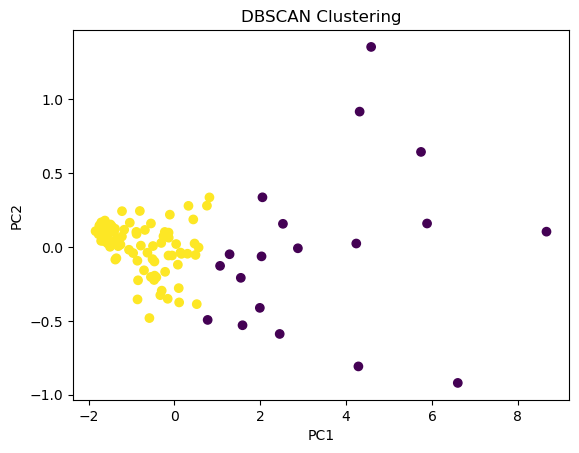

In [58]:
# compute DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(cleaned_data.iloc[:, 2:])

# print the number of clusters (-1 indicates outliers)
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print('Number of clusters:', n_clusters_)

# print the silhouette score (a higher score indicates better clustering)
silhouette_score = metrics.silhouette_score(cleaned_data.iloc[:, 2:], dbscan.labels_)
print('Silhouette score:', silhouette_score)

# plot the clusters
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=dbscan.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.show()